In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA


In [ ]:
# Load the MNIST dataset, False makes it return the data as a NumPy array
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')

# Flatten the images
X = mnist.data
y = mnist.target
#print(X.shape) #(70000, 784)

# Split the data
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

# Filter data for classes 3 and 4
mask_train = np.isin(y_train, ['3', '4'])
X_train, y_train = X_train[mask_train], y_train[mask_train]
mask_test = np.isin(y_test, ['3', '4'])
X_test, y_test = X_test[mask_test], y_test[mask_test]

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

pca_train = PCA(n_components=1)
X_pca_train = pca_train.fit_transform(X_train) #print(X_pca.shape) = (11973, 1)
X_pca_test = pca_train.fit_transform(X_test)

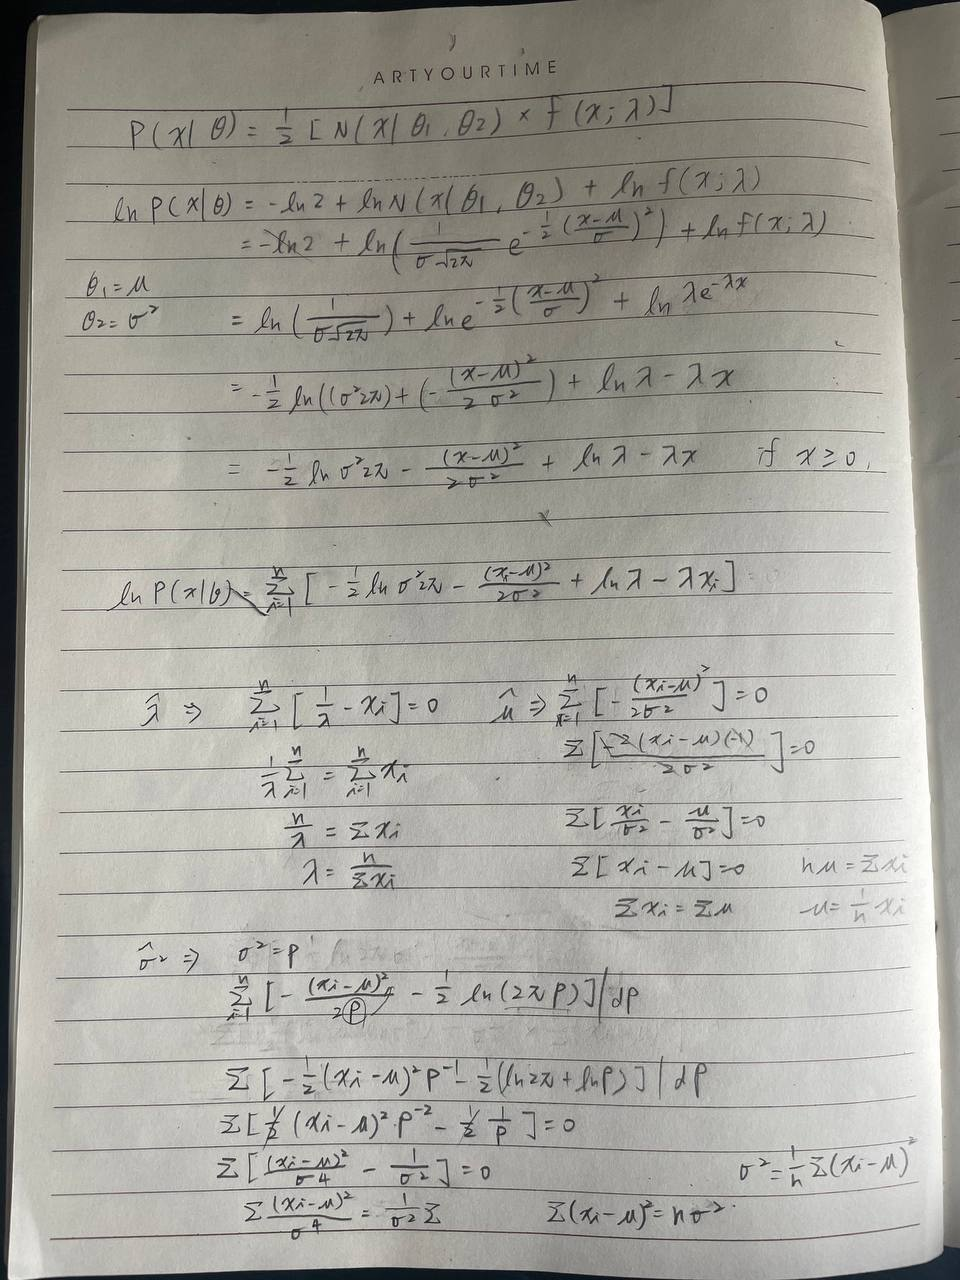

Exercise1 Q_2

Using the formula derived for the above distribution and the parameters derived for a Gaussian distribution in class, develop two ML classifiers using the training data of the two MNIST classes. Test the two ML classifiers on the test set of the MNIST dataset. Which of the two ML classifiers is the best? Why?

In [ ]:
# Gaussian
params ={}
for class_ in [3, 4]:
    X_class = X_train[y_train == class_]
    params[class_] = {
        'mean' : np.mean(X_class, axis=0),
        'variance' : np.var(X_class, axis=0)
    }

def gaussian_likelihood(x, mean, variance):
    variance += 1e-6  #  avoid division by zero
    return np.exp(- (x - mean)**2 / (2 * variance)) / np.sqrt(2 * np.pi * variance)

def classify(x):
    likelihoods ={}

    for class_ in [3, 4]:
        mean = params[class_]['mean']
        variance = params[class_]['variance']

        likelihood = gaussian_likelihood(x, mean, variance)

        likelihoods[class_] = likelihood

        max_likelihood_class = None
        max_likelihood_value = None

        for class_, likelihood in likelihoods.items():
            if max_likelihood_value is None or likelihood > max_likelihood_value:
                max_likelihood_class = class_
                max_likelihood_value = likelihood

        return max_likelihood_class

y_pred_gaussian = [classify(x) for x in X_pca_test]
accuracy_gaussian = np.mean(y_pred_gaussian == y_test)
print(f'Accuracy for Gaussian distribution: {accuracy_gaussian}')



Accuracy for Gaussian distribution: 0.5070281124497992


In [ ]:
# Exponential Gaussian
for class_ in [3, 4]:
    X_class = X_train[y_train == class_]
    params[class_]['lambda'] = 1 / np.mean(X_class)

def gaussian_exponential_likelihood(x, mean, variance, lambda_):
    gaussian = np.exp(- (x - mean)**2 / (2 * variance)) / np.sqrt(2 * np.pi * variance)
    exponential = lambda_ * np.exp(-lambda_ * x)
    return gaussian * exponential

def classify(x):
    likelihoods ={}

    for class_ in [3, 4]:
        mean = params[class_]['mean']
        variance = params[class_]['variance']
        lambda_ = params[class_]['lambda']

        likelihood = gaussian_exponential_likelihood(x, mean, variance, lambda_)

        likelihoods[class_] = likelihood

        max_likelihood_class = None
        max_likelihood_value = None

    likelihood = gaussian_exponential_likelihood(x, mean, variance, lambda_)

    likelihoods[class_] = likelihood

    max_likelihood_class = None
    max_likelihood_value = None

    for class_, likelihood in likelihoods.items():
        if max_likelihood_value is None or np.any(likelihood > max_likelihood_value):
            max_likelihood_class = class_
            max_likelihood_value = likelihood

    return max_likelihood_class

y_pred_gaussian_exponential = [classify(x) for x in X_pca_test]
accuracy_gaussian_exponential = np.mean(y_pred_gaussian_exponential == y_test)
print(f'Accuracy for Gaussian-exponential distribution: {accuracy_gaussian_exponential}')

<ipython-input-112-0694b1620a2a>:7: RuntimeWarning: divide by zero encountered in divide
  gaussian = np.exp(- (x - mean)**2 / (2 * variance)) / np.sqrt(2 * np.pi * variance)
<ipython-input-112-0694b1620a2a>:7: RuntimeWarning: invalid value encountered in divide
  gaussian = np.exp(- (x - mean)**2 / (2 * variance)) / np.sqrt(2 * np.pi * variance)


Accuracy for Gaussian-exponential distribution: 0.4929718875502008


Both of classifier performs not really well, cause we assumes the MNIST is a gaussian distribution or gaussian-exponential distribution. However, MNIST doesn't follow the gaussian distribution, because the images have a complex distribution due to variations in handwriting styles, digital shape.

Exercise1 Q1_3

Now let’s move on to the non-parametric estimation. User kernel-based density estimation with
a Gaussian kernel of σ = 20 to estimate the probability distributions of the two MNIST classes. Note that
σ represents the scaling factor for the Gaussian kernel. Use an ML-based classifier using this probability
estimation, and report the test accuracy on the MNIST dataset.

In [ ]:
def gaussian_kernel(x, y, sigma=20):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * sigma ** 2))

def kde(x, data, kernel_function, sigma):
    sum = 0
    for xi in data:
        # Add the kernel function value to the sum
        sum += kernel_function(x, xi, sigma)
    return sum / len(data)

X_pca_train_3 = X_pca_train[y_train == 3]
X_pca_train_4 = X_pca_train[y_train == 4]

def classify(sample):
    kde_3 = kde(sample, X_pca_train_3, gaussian_kernel, 20)
    kde_4 = kde(sample, X_pca_train_4, gaussian_kernel, 20)
    return 3 if kde_3 > kde_4 else 4

y_pred = [classify(sample) for sample in X_pca_test]
accuracy = np.mean(y_pred == y_test)
print(f'Test accuracy: {accuracy}')


Test accuracy: 0.9789156626506024


Exercise1 Q1-4

Comparing the non-parametric and the two parametric estimation methods, which one is the
best? Explain.

Non-parametric estimation method is much better, cause parametric estimation method makes the assumption for the data distribution. However, we can't make sure if the assumptsion is correct or not. For the non-parametric estimation method, it's more flexible and robust, especially when we don't know the data distribution. Moreover, we can use non-parametric method to check the assumptions of the parametric method.